In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()

import xgboost as xgb
from xgboost import XGBRegressor

c:\Anaconda\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Anaconda\lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("robikscube/hourly-energy-consumption")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\visha\.cache\kagglehub\datasets\robikscube\hourly-energy-consumption\versions\3


In [4]:
df = pd.read_csv(path + "/PJME_hourly.csv")

In [5]:
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [6]:
df.tail()

,Datetime,PJME_MW
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0
145365,2018-01-02 00:00:00,38608.0


In [7]:
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df.index
df = df.sort_index()

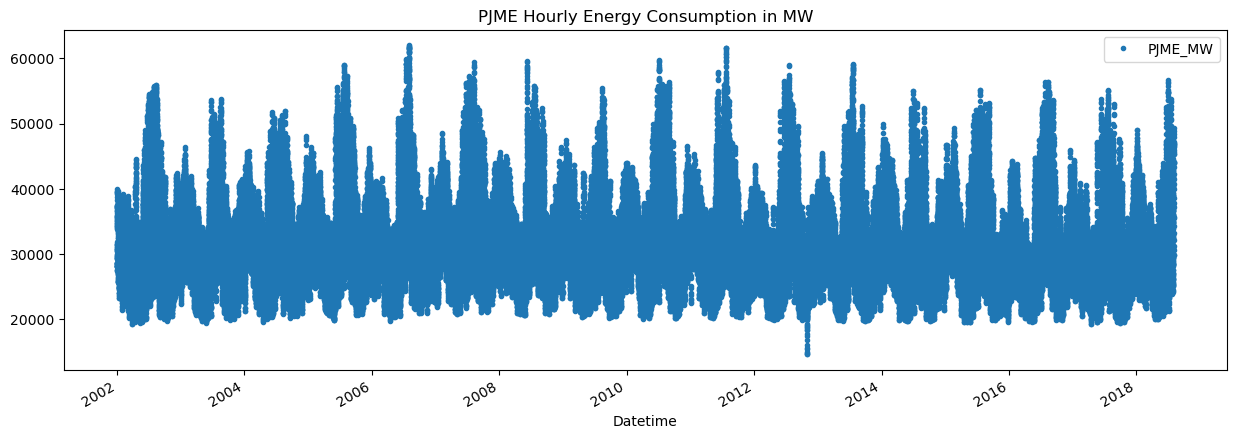

In [8]:
df.plot(figsize=(15, 5),
        style='.',
        title='PJME Hourly Energy Consumption in MW',
        color=color_pal[0])
plt.show()

# Train/Test Split #

In [9]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

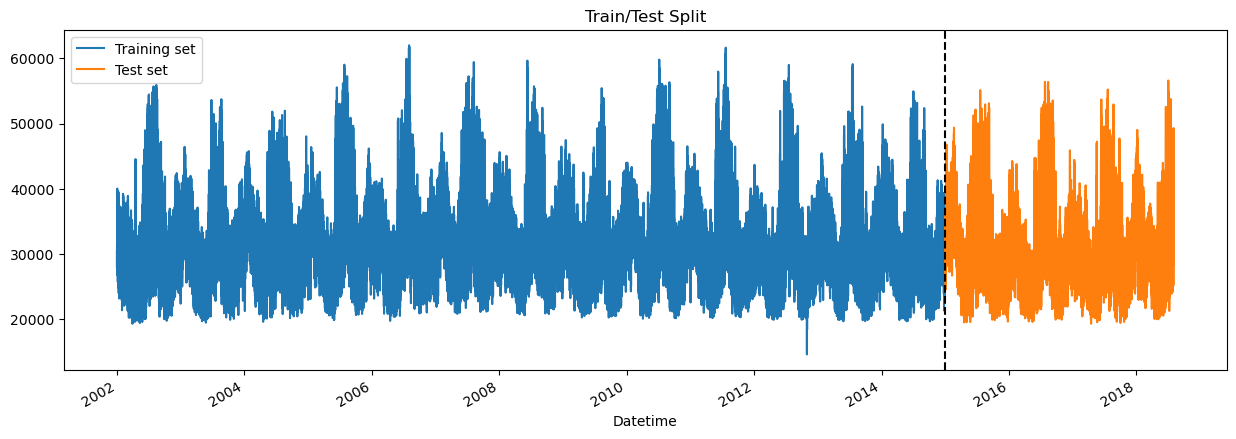

In [10]:
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Data',title='Train/Test Split')
test.plot(ax=ax, label='Test Data')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training set', 'Test set'])
plt.show()

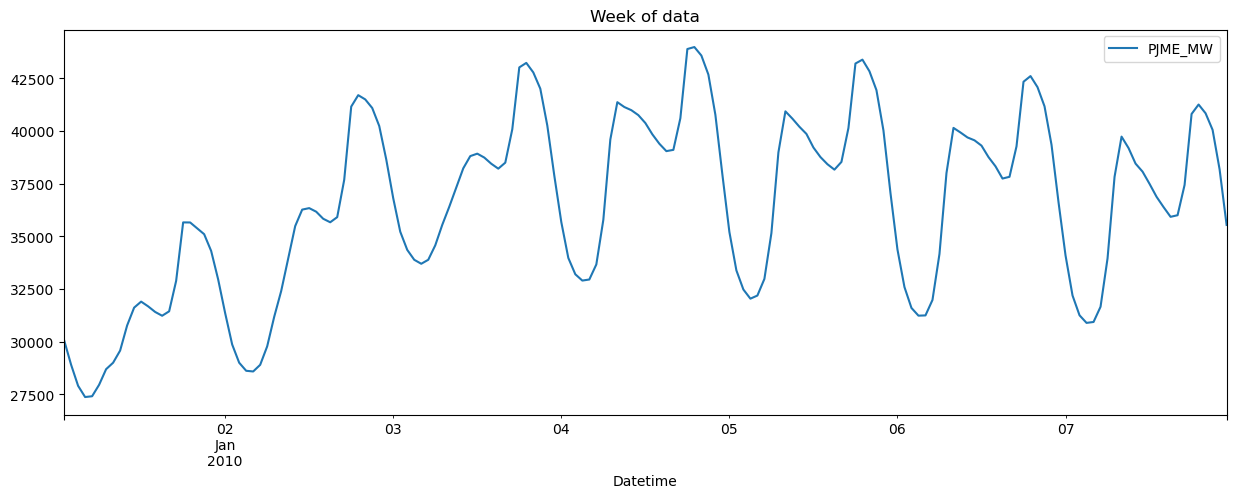

In [11]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5),
    title='Week of data',
    )
plt.show()

# Feature Engineering # 

In [12]:
def create_date_features(df):
    """
    Create time series features based on time series index
    """    
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

In [13]:
df = create_date_features(df)

# Visualize our Feature / Target Relationship

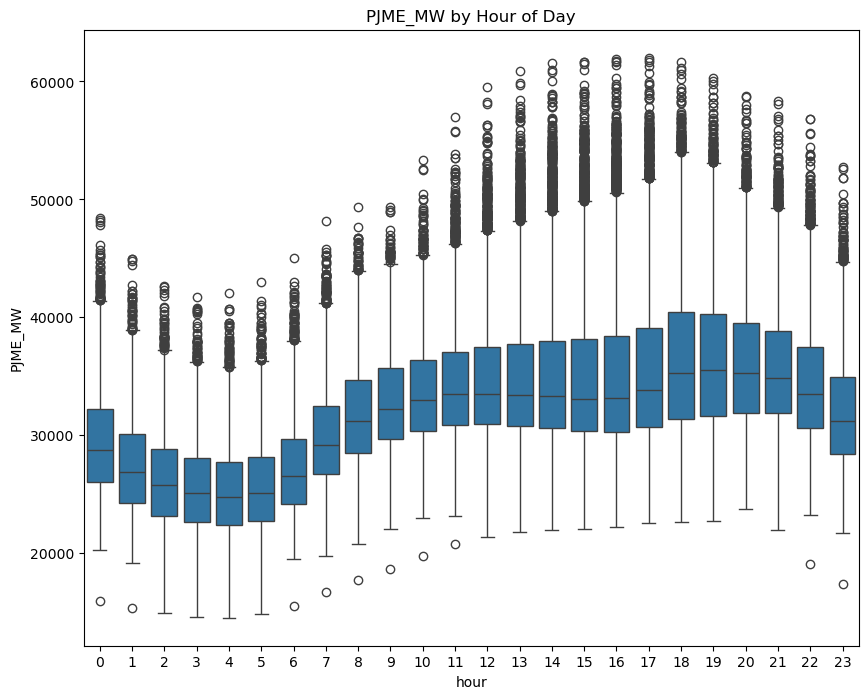

In [14]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(x='hour', y='PJME_MW', data=df)
ax.set_title('PJME_MW by Hour of Day')
plt.show()


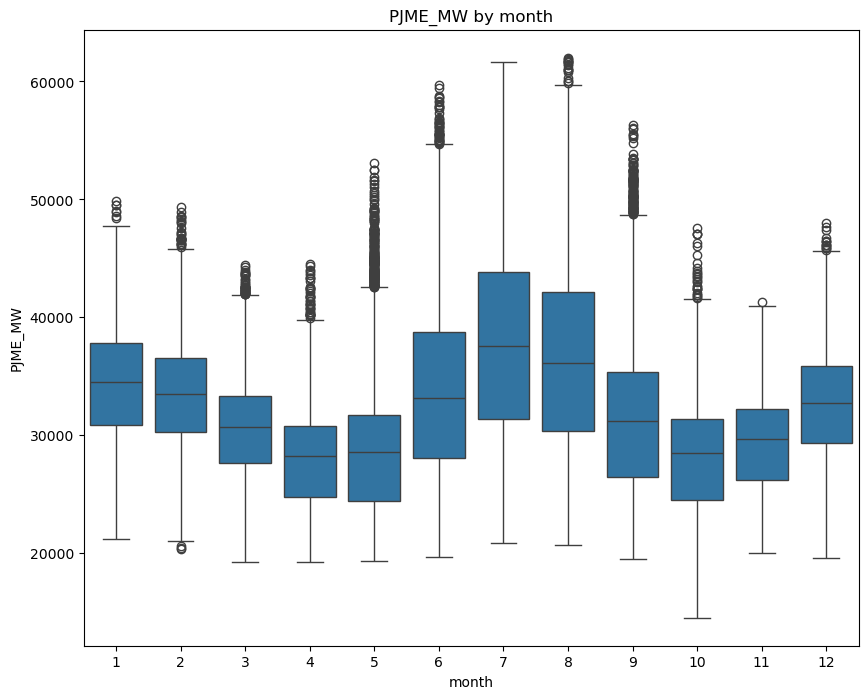

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(x='month', y='PJME_MW', data=df)
ax.set_title('PJME_MW by month')
plt.show()


# Model Creation

In [16]:
train = create_date_features(train)
test = create_date_features(test)

Features = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
Target = 'PJME_MW'

In [17]:
df.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear'],
      dtype='object')

In [18]:
X_train = train[Features]
y_train = train[Target]

X_test = test[Features]
y_test = test[Target]

In [19]:
reg = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.01, early_stopping_rounds=50)
reg.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:6407.35736	validation_1-rmse:6479.81619
[100]	validation_0-rmse:3911.97994	validation_1-rmse:4312.03224
[200]	validation_0-rmse:3244.38509	validation_1-rmse:3864.56545
[300]	validation_0-rmse:2996.08999	validation_1-rmse:3748.76687
[400]	validation_0-rmse:2830.28024	validation_1-rmse:3744.93340
[416]	validation_0-rmse:2804.52217	validation_1-rmse:3748.41719


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# Feature Importances

In [20]:
fi = pd.DataFrame(data = reg.feature_importances_,
             index = reg.feature_names_in_,
             columns=['importance'])

In [21]:
fi

,importance
hour,0.463878
dayofweek,0.162005
quarter,0.028881
month,0.203161
year,0.023824
dayofyear,0.118251


<AxesSubplot:>

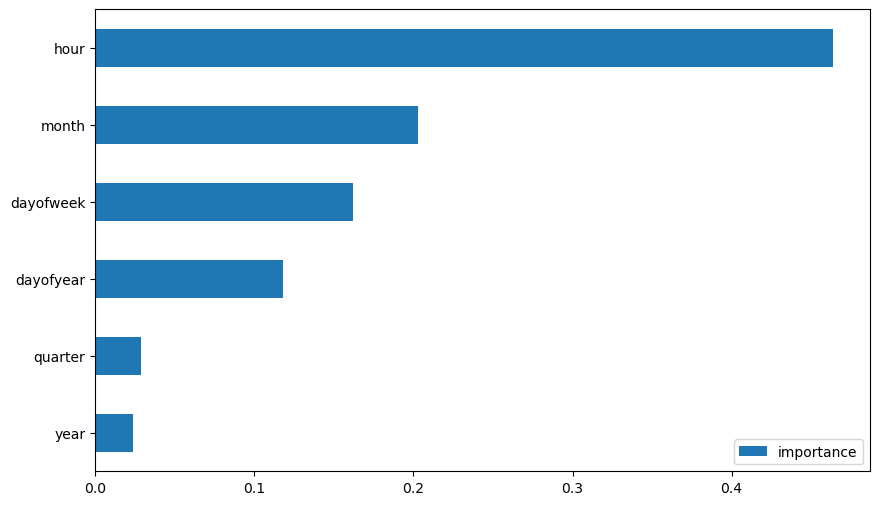

In [22]:
fi.sort_values(by='importance', ascending=True).plot.barh(figsize=(10, 6), color=color_pal[0], legend=True)

# Forecast On the Test Set

In [23]:
test['prediction'] = reg.predict(X_test)

In [24]:
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

In [25]:
df

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,prediction
Datetime,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,NaN
...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,41545.953125
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,41135.625000
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,39968.492188


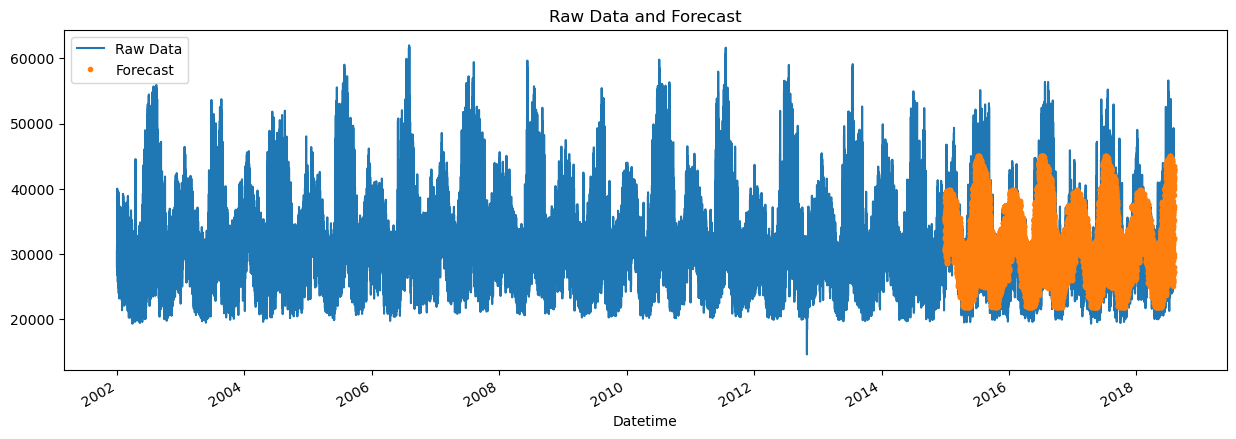

In [26]:
ax = df[['PJME_MW']].plot(figsize=(15, 5), color=color_pal[0], title='PJME Energy Consumption and Forecast')
df[['prediction']].plot(ax=ax, color=color_pal[1],style='.')
plt.legend(['Raw Data', 'Forecast'])
ax.set_title('Raw Data and Forecast')
plt.show()

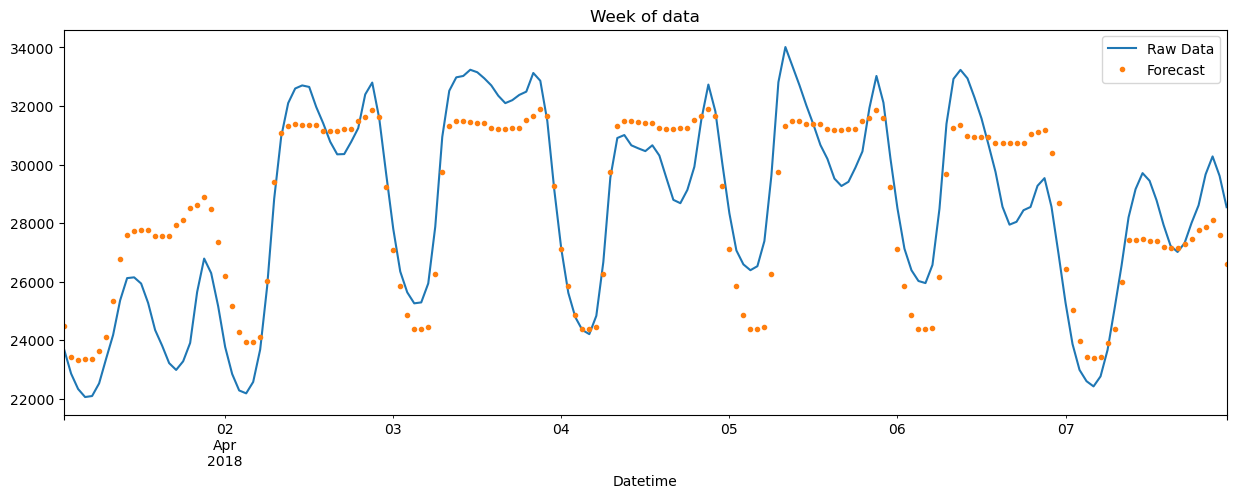

In [27]:
ax = \
    df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW']\
    .plot(figsize=(15, 5),title='Week of data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction']\
    .plot(style='.')
plt.legend(['Raw Data', 'Forecast'])
plt.show()

In [29]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3741.03


In [31]:
test['error'] = np.abs(test[Target] - test['prediction'])
test['date'] = test.index.date

In [32]:
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2016-08-13    13829.866211
2016-08-14    13577.304362
2016-09-10    11235.855143
2016-09-09    11032.220215
2016-08-12    10667.820312
2018-01-06    10407.698161
2015-02-20    10143.611491
2017-05-19     9495.122640
2016-07-04     9440.610596
2016-07-23     9362.332682
Name: error, dtype: float64